<a href="https://colab.research.google.com/github/bepti/colab/blob/main/process_imu_bin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
os.getcwd()

'/content'

In [2]:
dir = '/content/mydata'
if not os.path.exists(dir):
    os.mkdir(dir)
os.chdir(dir)
for f in os.listdir():
  os.remove(f)
!wget https://github.com/bepti/colab/raw/main/data.zip

--2021-11-18 16:43:18--  https://github.com/bepti/colab/raw/main/data.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bepti/colab/main/data.zip [following]
--2021-11-18 16:43:19--  https://raw.githubusercontent.com/bepti/colab/main/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1747664 (1.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.67M  --.-KB/s    in 0.07s   

2021-11-18 16:43:19 (23.2 MB/s) - ‘data.zip’ saved [1747664/1747664]



In [3]:
with zipfile.ZipFile('data.zip') as myzip:
  myzip.extractall()
os.remove('data.zip')
files = os.listdir()
files.sort()

In [4]:
rows = []
for dfile in files:
  f = open(dfile,'rb')
  exec=dfile[:-14]
  start=dfile[-14:-4]
  b = f.read(16)
  while len(b)>0:
    time_ms = int.from_bytes(b[0:4], byteorder='big', signed=True)
    imus = [exec,start,time_ms]
    for i in range(6):
      imus.append(int.from_bytes(b[i*2+4:i*2+6], byteorder='big', signed=True))
    rows.append(imus)
    b = f.read(16)  
  f.close()
print('number of samples:',len(rows))
df = pd.DataFrame(rows,columns=['exec','start','time_ms','acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z'])

number of samples: 125155


In [ ]:
fig, axs = plt.subplots(10, 4, figsize=(30,40))
samples=df.groupby(['exec','start'], as_index=False)['exec'].count()
for i in range(120,127):
  start = samples.iloc[i,0]
  dff = df[df['start']==start].copy().reset_index(drop=True)
  max_dev_var = dff.describe().loc['std','acc_x':].idxmax()
  ax=axs[i%40//4,i%4]
  dff[max_dev_var].plot(ax=ax, title=dff.loc[0,'exec'] +' - '+ dff.loc[0,'start'], label=max_dev_var)
  ax.vlines([50,ax.get_xlim()[1]-100],ax.get_ylim()[0],ax.get_ylim()[1], colors=['g','r'])
  ax.hlines([0],ax.get_xlim()[0],ax.get_xlim()[1], colors=['grey'])
  ax.legend()




In [29]:
len(samples)

127

In [ ]:
# Kísérlet: periódusokra vágni a mintákat majd öszefűzni a gyakorlatokat:
# Kiválasztom a hat csatorna közül a legnagyobb szórásút (amplitudó), feltételezve hogy ez a csatorna lesz a legjellemzőbb a periódusokra
# nyilván ennek nem lesz köze a kettlebell gyakorlat "elejéhez" de ez alapjában véve nem lényeges (azt hiszem)
# A szándék, hogy a sok azonos gyakorlatot összefűzöm egy nagy többszáz ciklusos virtuális gyakorlattá és abból walk-forward módon egyforma (átfedő) szeleteket vágok a tanításhoz
for i in range(len(samples)):
  start = samples.iloc[i,0]
  dff = df[df['start']==start].copy().reset_index(drop=True)
  max_dev_var = dff.describe().loc['std','acc_x':].idxmax()
  dff[max_dev_var]=dff[max_dev_var].rolling(50, center=True).mean()
  #dff=dff.iloc[50:-150,:]
  offset=dff[max_dev_var].quantile(0.28) #<---olya
  dff['zerocross']=(np.sign(dff[max_dev_var]-offset)-np.sign(dff[max_dev_var].shift(1,fill_value=0)-offset))/2
  plt.figure(figsize=(20,7))
  plt.plot(dff.index,dff[max_dev_var])
  plt.hlines([offset],dff.index.min(),dff.index.max() )
  plt.vlines(dff[dff['zerocross']==1]['zerocross'].index,offset-1000,offset+1000)
  plt.show()


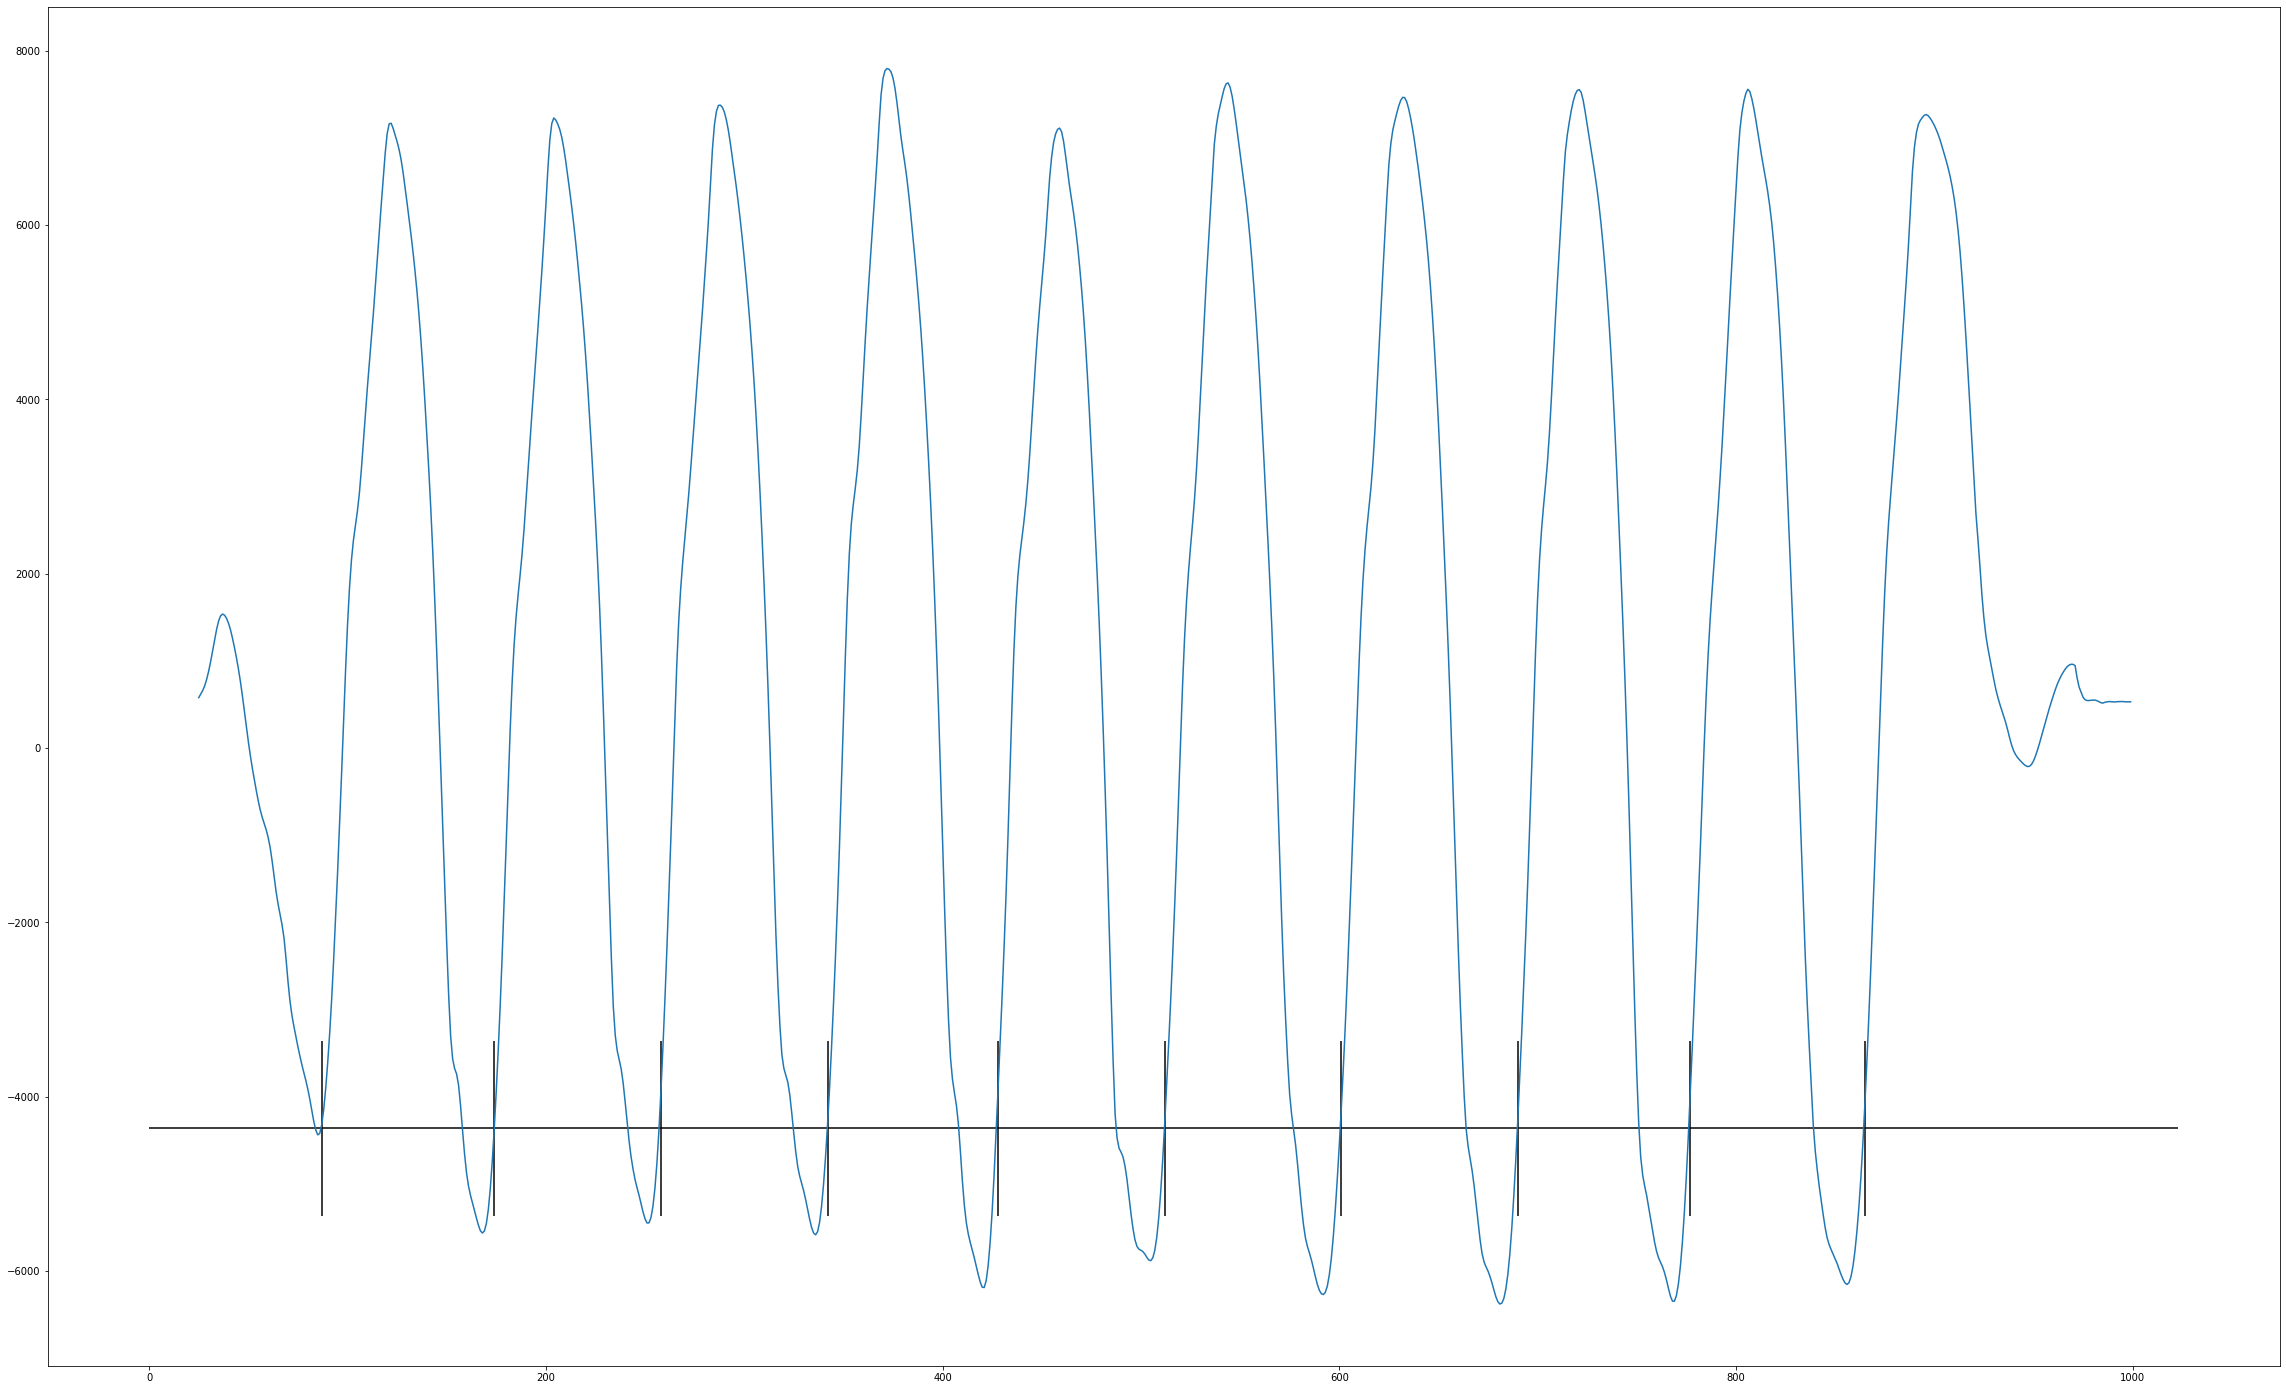

In [7]:
dff = df[df['start']=='1121094403'].copy().reset_index(drop=True)
max_dev_var = dff.describe().loc['std','acc_x':].idxmax()
max_dev=dff[max_dev_var].rolling(50, center=True).mean()
#dff=dff.iloc[50:-150,:]
offset=max_dev.quantile(0.28)
zerocross=(np.sign(max_dev-offset)-np.sign(max_dev.shift(1,fill_value=0)-offset))/2
plt.figure(figsize=(20,7))
plt.plot(dff.index,max_dev)
plt.hlines([offset],dff.index.min(),dff.index.max() )
plt.vlines(zerocross[zerocross==1].index,offset-1000,offset+1000)



In [8]:
zerocross[zerocross==0]

26     0.0
27     0.0
28     0.0
29     0.0
30     0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: gyr_x, Length: 954, dtype: float64

In [9]:
zerocross_sign(-5,+6)

NameError: ignored

In [ ]:
stat=df.groupby(['start','exec'])['start'].count()
stat[stat>1000]

In [ ]:
dff = df[df['start']=='1028191610'].copy().reset_index(drop=True)

In [ ]:
#jáccós


In [ ]:
fig = go.Figure(layout_title_text=dff.iloc[0]['start']+' '+dff.iloc[0]['exec'])

fig.add_trace(go.Scatter(x=dff.index,y=df['acc_x'],
                    mode='lines', name='gyorsulX',
                   hovertext=df['time_ms']))
fig.add_trace(go.Scatter(x=dff.index,y=df['acc_y'],
                    mode='lines', name='gyorsulY', hovertext=df['time_ms']))
fig.add_trace(go.Scatter(x=dff.index,y=df['acc_z'],
                    mode='lines', name='gyorsulZ', hovertext=df['time_ms']))
fig.add_trace(go.Scatter(x=dff.index,y=df['gyr_x'],
                    mode='lines', name='fordulX', hovertext=df['time_ms']))
fig.add_trace(go.Scatter(x=dff.index,y=df['gyr_y'],
                    mode='lines', name='fordulY', hovertext=df['time_ms']))
fig.add_trace(go.Scatter(x=dff.index,y=df['gyr_z'],
                    mode='lines', name='fordulZ', hovertext=df['time_ms']))
fig.update_layout(hovermode="x")
fig.show()

In [ ]:
col_var = dff.describe().loc['std','acc_x':].idxmax()

In [ ]:
df_var = dff[[col_var]].copy()

col_var

In [ ]:
df_var=df_var.rolling(5, center=True).mean()[39:620].reset_index(drop=True)

In [ ]:
df_var.plot()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
autoc = acf(df_var[col_var], nlags=300, fft=True)
plt.plot(df_var.index[:len(autoc)],autoc)
#plt.plot([0,400],[0,0])
#plt.plot(df_var.index,(df_var[col_var])/500)
plt.xlim(0,50)
plt.show()

In [ ]:
df_ac=pd.DataFrame(autoc, columns=['ac'])

In [ ]:
list(df_ac[np.sign(df_ac['ac'].shift(-1))!=np.sign(df_ac['ac'])].index)


In [ ]:
nefuss

In [ ]:
pip install ipycanvas

In [ ]:
import numpy as np
import ipycanvas

In [ ]:
df['gyr_x_'] = ((df['gyr_x']/32768)*1000)*(np.pi/180) #átszámolom radiánba (1000°/sec az érzékenység)
df['gyr_x_'].describe()

In [ ]:
nefuss
from google.colab import output
output.enable_custom_widget_manager()
from ipycanvas import Canvas, hold_canvas, RoughCanvas
from time import sleep

canvas = Canvas(width=200, height=200)
display(canvas)

# Number of steps in your animation
canvas.translate(100,100)
canvas.fill_style = 'black'
canvas.fill_rect(-100, -100, 200, 200)
for i in df['gyr_x_']:
    with hold_canvas(canvas):
        canvas.fill_style = 'black'
        canvas.fill_rect(-30, -30, 60, 60)
        canvas.rotate(i/40)
        # Perfom all your drawings here
        canvas.fill_style = 'red'
        canvas.fill_polygon([(0, -20), (-20, 20), (20, 20)])        
        canvas.fill_style = 'orange'
        canvas.fill_polygon([(0, -20), (-5, -10), (5, -10)])        
    # Animation frequency ~50Hz = 1./50. seconds
    sleep(0.1)

In [ ]:
plt.plot(df_var.index,np.abs(np.fft.fft( df_var )))
plt.plot(df_var.index, df_var )
plt.xlim(0,40)

In [ ]:
pip install tsfresh

In [ ]:
from tsfresh.feature_extraction.feature_calculators import agg_autocorrelation

In [ ]:
agg_autocorrelation(df_var,  param={'f_agg': df_var} )